# Prepare GPX File for RGT Magic Road Upload

Use gpxpy for loading GPX File

https://pypi.org/project/gpxpy/

## SRTM Data

https://github.com/tkrajina/srtm.py

In [28]:
#!pip install gpxpy --upgrade
#!pip install SRTM.py --upgrade

In [29]:
import gpxpy
import gpxpy.gpx

# Parsing an existing file:
# -------------------------

gpx_file = open('hockenheimring-magic-road.GPX', 'r')

gpx = gpxpy.parse(gpx_file)

#for track in gpx.tracks:
#    for segment in track.segments:
#        for point in segment.points:
#            pass
           # print('Point at ({0},{1}) -> {2}'.format(point.latitude, point.longitude, point.elevation))

gpx_points = gpx.tracks[0].segments[0].points

print(gpx_points[0].latitude)

49.326423928141594


In [30]:
import pandas as pd 

df = pd.DataFrame([[s.latitude, s.longitude, s.elevation] for s in gpx_points], columns=['latitude', 'longitude', 'elevation'])

In [31]:
df

,latitude,longitude,elevation
0,49.326424,8.566839,101.199997
1,49.326458,8.566810,101.199997
2,49.326492,8.566784,101.199997
3,49.326524,8.566759,101.199997
4,49.326555,8.566735,101.199997
...,...,...,...
1175,49.326286,8.566948,107.199997
1176,49.326317,8.566925,107.199997
1177,49.326351,8.566902,107.199997
1178,49.326384,8.566877,107.199997


<AxesSubplot:xlabel='longitude'>

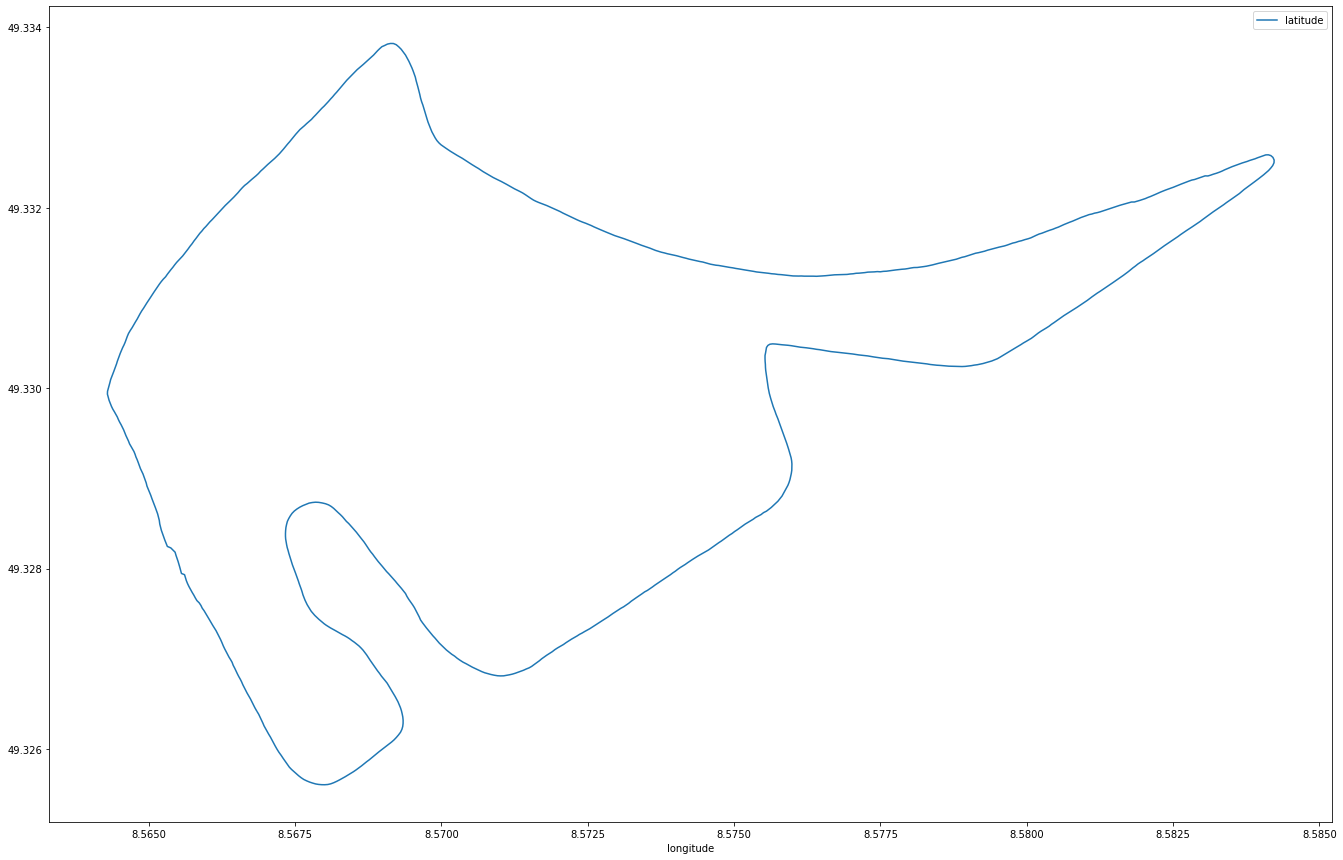

In [33]:
df.plot(x='longitude', y='latitude', figsize=[23, 15])

<AxesSubplot:>

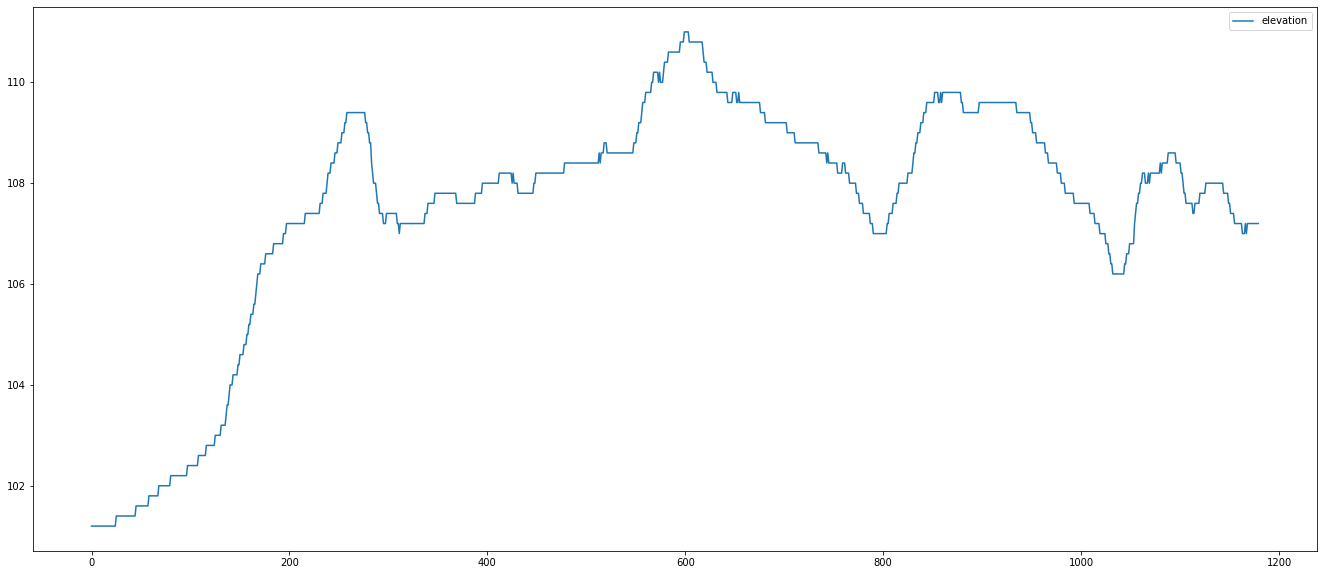

In [34]:
df.plot(y='elevation', figsize=[23, 10])